# Part 4: Article Summarizer
New Articles can often be long and descriptive. Analyzing these articles  manually, as you can imagine, is really time-consuming. This is where the brilliance of Natural Language Processing can be applied to generate a summary for long articles.
We will be working on the NY Times Articles.<br>
<b>Our objective</b> here is to generate a summary for the NY Times articles using the extraction-based approach.



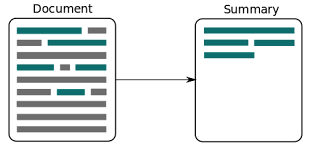

In [1]:
#Import Required Libraries
import pandas as pd
import numpy as np
from pandas import DataFrame

#Preprocessing & tokeninzing 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
import datetime, nltk, warnings

#Similarity matrix 
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import heapq

#Webscrapping 
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from tqdm import tqdm
from webdriver_manager.chrome import ChromeDriverManager

Using TensorFlow backend.


In [4]:
#Read the Data
df = pd.read_csv('ArticlesText.csv')
df = df.drop(['articleID', 'byline','documentType','keywords','multimedia','newDesk','printPage','pubDate','sectionName','source','typeOfMaterial','articleWordCount'], axis=1)
df.head(1)

,headline,snippet,webURL,text
0,G.O.P. Leadership Poised to Topple Obama’s Pi...,The most powerful and ambitious Republican-led...,https://www.nytimes.com/2017/01/01/us/politics...,"With New Congress Poised to Convene, Obama’s P..."


### 4.1 Webscrapping using selenium 
We have used the beautifulSoup4 library earlier in the EDA for webscrapping, below we have mentioned a different approach that can be used for webscrapping for reference. In this approach, we have used libraries such as selenium & Chromedriver <i>(You will need selenium & chromedriver installed on your local machine)</i>
If you want you can replace the dataframe with URL of your choice. Here, we are performing webscrapping on only one article for demo purpose.
<br>Chromedriver : https://sites.google.com/a/chromium.org/chromedriver/downloads
<br>Selenium : pip install selenium

In [5]:
#Function for fetching articles from url  
def get_content(url):
    chrome_options = Options()
    
    #Chromedriver location on local machine
    driver = webdriver.Chrome('/Users/lisaapatel/.wdm/drivers/chromedriver/83.0.4103.39/mac64/chromedriver')
    driver.maximize_window()
    
    #Fetching data from url
    driver.get(url)
    
    try:
        #Fetching only text inside 'P' tags(Assuming article text will be in paragraphs)
        content = driver.find_elements_by_tag_name('p')
        s = ""
        if len(content) > 0:
            for i in range(len(content)):
                s = s + content[i].text
        dataset.append(s)
        
    except:
        #Will throw an exception if url is not working 
        print("Error occured at: " + url)
        
    driver.close()

In [6]:
l=[]
#Here, fetching data only for one article 
for url in df["webURL"].iloc[1:2]:
    l.append(url)

In [7]:
#Append articles to list 
dataset = []
for url in tqdm(l[0:1]):
    get_content(url)

100%|██████████| 1/1 [00:15<00:00, 15.35s/it]


In [8]:
#Creating a new dataframe 
A_df = DataFrame(dataset,columns=['Article'])

#Adding column 'Snippet' to dataframe 
A_df['Snippet'] = df['snippet']

#Defing Article lengths 
A_df['Article_len'] = A_df['Article'].apply(lambda x: len(x) - x.count(" "))

In [9]:
A_df.head()

,Article,Snippet,Article_len
0,A strategy that went from a “good war” to the ...,The most powerful and ambitious Republican-led...,14206


### 4.2 Extractive Summarization
The name gives away what this approach does. We identify the important sentences or phrases from the original text and extract only those from the text. Those extracted sentences would be our summary. The below diagram illustrates extractive summarization:

 <div>
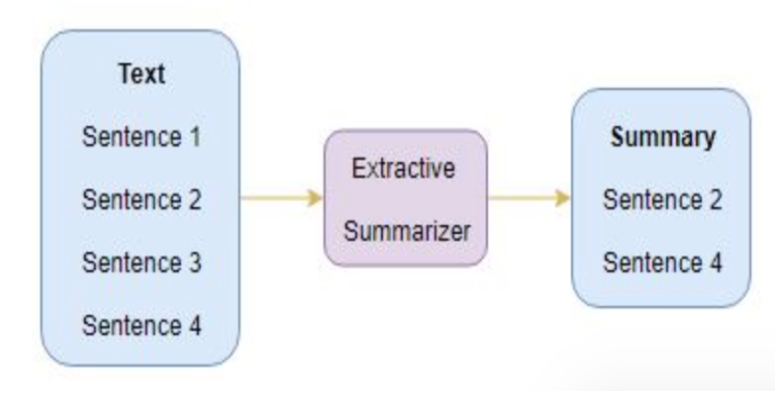
</div>

### Our Approach 
<br>
<li>Data collection from web through web-scraping</li>
<li>Data Cleanup (remove special characters, numeric values, stopwords, punctuations)</li>
<li>Tokenization - Creation of tokens (Sentences tokens)
<li>Find vector representation (word embeddings) for each and every sentence
<li>Build Similarity matrix with calculated sentence vectors
<li>Similarity matrix is converted to graph using Pagerank, where sentences will be vertices and similarity score as edges.
<li>Calculate sentence ranks
<li>Creation of summary with top N highest scored sentences 


 <div>
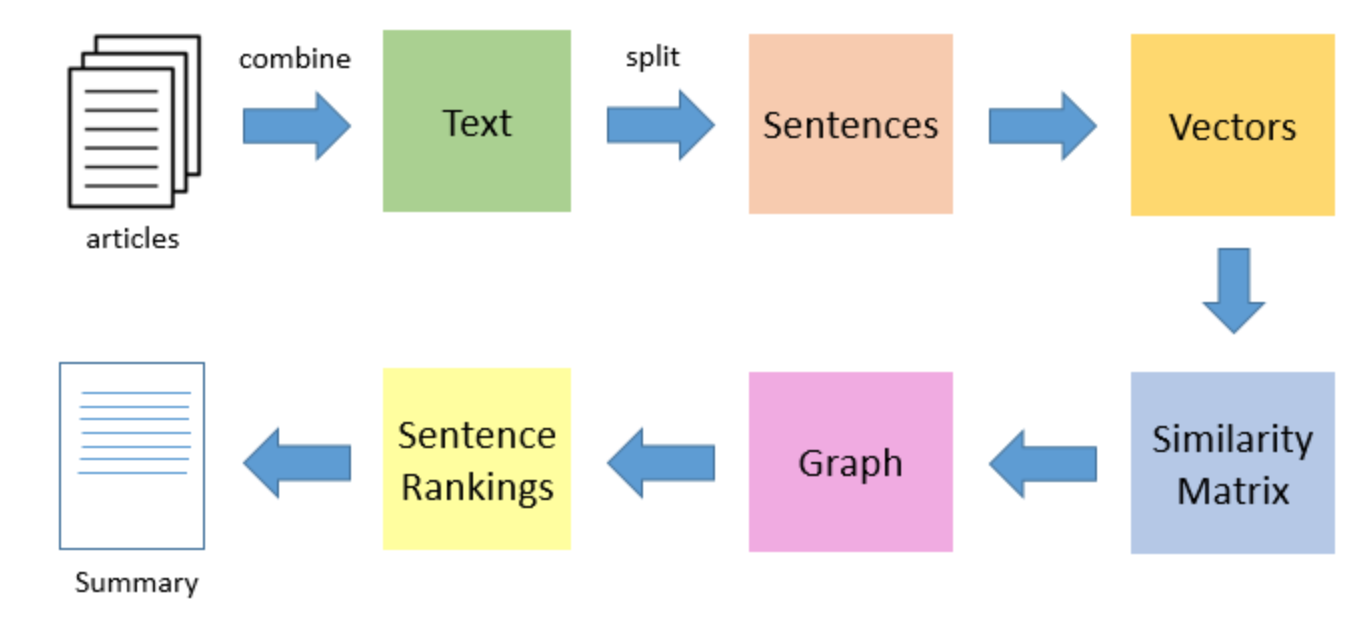
</div>


### Split Text into Sentences
<br>Using the sent_tokenize( ) function of the nltk library we will break the Article into individual sentences.</br>
<br>It converts paragraphs into sentences which are stored in a 2D - List(Sentences)

In [10]:
#split the the text in the articles into sentences
sentences = []
for s in A_df['Article']:
    article_str = BeautifulSoup(s, "lxml").text
    article_str = article_str.replace('\n', ' ')
    article_str = re.sub(r'^https?:\/\/.*[\r\n]*', '', article_str, flags=re.MULTILINE)
    sentences.append(sent_tokenize(article_str))

In [11]:
#flatten the list
sentences = [y for x in sentences for y in x]

### Output:

Sentences after tokenization 

In [12]:
sentences[10:11]

['Obama was a state senator from Illinois in October 2002 when he famously condemned Iraq as a “dumb war.” But in the same speech he also said, “I don’t oppose all wars.” He was referring to Afghanistan, which he viewed as a just war to hunt down the perpetrators of the Sept. 11 terrorist attacks.“I would willingly take up arms myself to prevent such tragedy from happening again,” he told the crowd that day in Chicago’s Federal Plaza.By July 2008, as the Democratic nominee for president, Mr. Obama had embraced Afghanistan as a priority over Iraq — the “good war,” in a phrase that he never actually used himself but that became so associated with his approach it was sometimes wrongly attributed to him.ADVERTISEMENTMr.']

### Preprocessing Articles 


List of Task Performed:
<li> Removing punctuations, numbers and special characters </li>
<li> Converting sentences to lowercase </li>
<li> Removing all the stopwords </li>

In [13]:
stop_words = stopwords.words('english')
def clean_article(text):
    
    clean_sentences = pd.Series(text).str.replace("[^a-zA-Z]+", " ")
    clean_sentences = pd.Series(text).str.replace("'\([^)]*\)'", " ")
    clean_sentences = pd.Series(text).str.replace('"','')
    clean_sentences = [s.lower() for s in clean_sentences]
      
    sen_new = " ".join([i for i in clean_sentences if i not in stop_words])
    
    return sen_new
      
clean_sentences = [clean_article(r.split()) for r in sentences]

### Output

Cleaned sentences after Pre-preprcossing 

In [14]:
clean_sentences[6:8]

['optimistic president thought afghanistan winnable had, bitter experience, become commander chief forever war.he remains defensive lessons journey.',
 '“we shouldn’t assume every time country problems reflects failure american policy,” president said interview september.advertisementnow, mr. obama prepares turn war donald j. trump, leader even skeptical value american engagement foreign conflicts, afghanistan captures disillusionment man believed, put 2009 nobel peace prize acceptance speech, “that war sometimes necessary, war level expression human folly.”more conflict, afghanistan shaped mr. obama’s thinking basic questions war, peace use military power.']

### Vector Representation of Sentences
Here, we created vectors for sentences in our data using the clean sentences & GloVe vectors
<br>We used the pre-trained Wikipedia 2014 + Gigaword 5 GloVe vectors <i>(Warning glove file is 858mb)</i>

In [15]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove*.zip

In [16]:
#Extract word vectors
word_embeddings = {}

#Read the glove file with N=100
gloveFile = open('/Users/lisaapatel/Documents/try /glove.6B/glove.6B.100d.txt', encoding='utf-8')

for line in gloveFile:
    #Separate the words from the coeffients 
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    
    #Create dictionary with words as the key and the values as the coeffients 
    word_embeddings[word] = coefs
gloveFile.close()

#### The total number of word vectors are 400001. This word vectors are stored in word_embeddings which we will use as our dictionary

In [17]:
len(word_embeddings)

400001

In [23]:
sentence_vectors = []

for i in clean_sentences:
    
    if len(i) != 0:
        #Create vectors of the sentences using the word_embeddings created about 
        vect = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
    else:
        #However, if no sentence is present intialize the vector with zeros
        vect = np.zeros((100,))
        
    #The sentence vector list will be used in cosine similarity matrix for comparision
    sentence_vectors.append(vect)

### 4.3 Similarity Matrix using PageRank Algorithm

In [24]:
#Similarity matrix
similarity_mat = np.zeros([len(sentences), len(sentences)])

#Calculate cosine similarity for each pairs of sentences except for the sentences itself(i.e i = j)
for i in range(len(sentences)):
    for j in range(len(sentences)):
        if i != j:
            similarity_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]

#Using the similarity matrix calculate the pagerank scores 
graph_nx = nx.from_numpy_array(similarity_mat)
scores = nx.pagerank(graph_nx)

### Summary Extraction
<li>Sorting sentences 
<li>Extracting top 5 ranked sentences

In [25]:
#Sorts sentences according to their highest pagerank scores 
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)

In [26]:
#Extracting top 5 ranked sentences(number of senteces can be changed)
summary_sentences = heapq.nlargest(5,ranked_sentences)

In [27]:
#Printing Article,Snippet & Summary 
for i in range(1):
    
    #Article
    print("Article :",A_df['Article'][i])
    print("\n")
    #Snippet
    print("Snippet :",A_df['Snippet'][i])
    print("\n")
    #Summary 
    print("Summary :",summary_sentences[i][1])
    print("\n")

Article : A strategy that went from a “good war” to the shorthand “Afghan good enough” reflects the president’s coming to terms with what was possible in Afghanistan.President Obama visited Section 60 of Arlington National Cemetery on Veterans Day in 2009. Section 60 is where many American soldiers killed in Afghanistan and Iraq are buried.
Credit...
Luke Sharrett/The New York TimesBy Mark LandlerWASHINGTON — President Obama’s advisers wrestled with an intractable problem in the spring and summer of 2015: How could they stabilize Afghanistan while preserving Mr. Obama’s longtime goal of pulling out the last American troops before he left office?As it happened, the president solved the problem for them. In early August of that year, when Mr. Obama convened a meeting of the National Security Council, he looked around the table and acknowledged a stark new reality.“The fever in this room has finally broken,” the president told the group, according to a person in the meeting. “We’re no lon